In [ ]:
# %pip install -q -r requirements.txt

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from common.utils import get_progress_bar
from gridworld.gridworld import GridWorld
from gridworld.room_design import two_room_design as room_design
from stomp.framework import STOMP

In [2]:
%load_ext autoreload
%autoreload 1
%aimport stomp.framework
%aimport gridworld.gridworld


In [3]:
num_runs = 1
all_runs = []

In [4]:
progress_bar = get_progress_bar(num_runs)

for run in progress_bar:
    env = GridWorld(room_design)
    stomp = STOMP(env, alpha_step_size=1)

    env.reset()
    option_learning_logs, options_model_learning_logs, planning_logs = stomp.learn(
        log_freq=None
    )
    all_runs.append((option_learning_logs, options_model_learning_logs, planning_logs))

    progress_bar.refresh()

  0%|          | 0/1 [00:00<?, ?it/s]


Learning options for hallway 0 with 50000 off-policy steps...

Logs saved for hallway 0.


w_options saved!

Learning models for Option 0, a Primitive Action, with 50000 off-policy steps...

Logs saved for option 0.


Learning models for Option 1, a Primitive Action, with 50000 off-policy steps...

Logs saved for option 1.


Learning models for Option 2, a Primitive Action, with 50000 off-policy steps...

Logs saved for option 2.


Learning models for Option 3, a Primitive Action, with 50000 off-policy steps...

Logs saved for option 3.


Learning models for Option 4, a Full Option, with 50000 off-policy steps...

Logs saved for option 4.

\w_rewards and W_transitions saved!

Planning with the learned options with 6000 operations steps...

\w saved!

Learning Finished!


In [5]:
learning_options_start_state_estimative = []
planning_start_state_estimative = []
for run in all_runs:
    # Let's consider only the two rooms experiment
    # Therefore we have only one hallway
    learning_options_start_state_estimative.append(run[0][0])
    planning_start_state_estimative.append(run[2])
learning_options_start_state_estimative = np.stack(
    learning_options_start_state_estimative
)
planning_start_state_estimative = np.stack(planning_start_state_estimative)
learning_options_start_state_estimative.shape, planning_start_state_estimative.shape

((1, 50000), (1, 6000))

In [6]:
learning_options_start_state_estimative_mean = np.mean(
    learning_options_start_state_estimative, axis=0
)
learning_options_start_state_estimative_std = np.std(
    learning_options_start_state_estimative, axis=0
)
(
    learning_options_start_state_estimative_mean.shape,
    learning_options_start_state_estimative_std.shape,
)

((50000,), (50000,))

In [7]:
planning_start_state_estimative_mean = np.mean(planning_start_state_estimative, axis=0)
planning_start_state_estimative_std = np.std(planning_start_state_estimative, axis=0)
planning_start_state_estimative_mean.shape, planning_start_state_estimative_std.shape

((6000,), (6000,))

In [8]:
def plot_arrays(mean_array, std_array, plotting_info):
    # Create figure and axis
    plt.figure(figsize=(20, 6))

    # Generate x-axis points (assuming these are sequential steps/episodes)
    x = np.arange(len(mean_array))

    # Plot mean line with shaded standard deviation
    plt.plot(x, mean_array, "b-", label="Mean")
    plt.fill_between(
        x,
        mean_array - std_array,
        mean_array + std_array,
        color="b",
        alpha=0.2,
        label="Standard Deviation",
    )

    # Customize the plot
    plt.xlabel(plotting_info["xlabel"])
    plt.ylabel(f"{plotting_info['ylabel']}\n(Average Over 100 runs)")
    plt.title(plotting_info["title"])
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

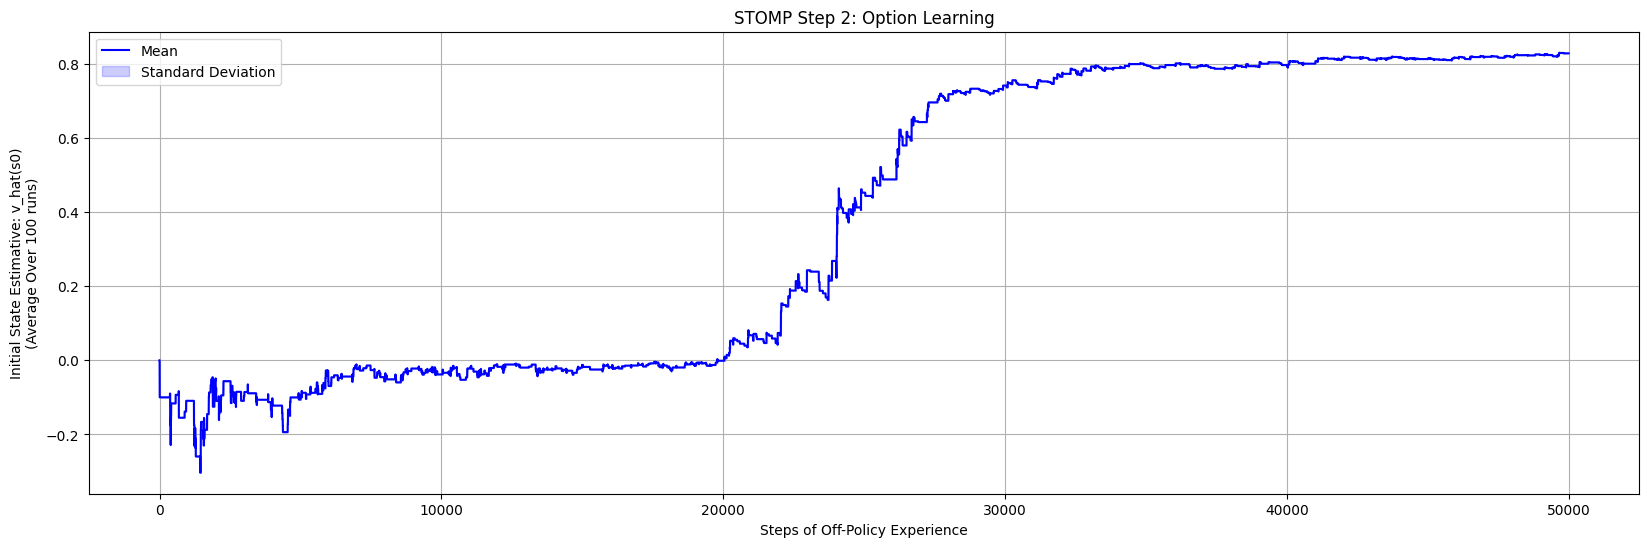

In [9]:
plot_arrays(
    learning_options_start_state_estimative_mean,
    learning_options_start_state_estimative_std,
    {
        "xlabel": "Steps of Off-Policy Experience",
        "ylabel": "Initial State Estimative: v_hat(s0)",
        "title": "STOMP Step 2: Option Learning",
    },
)

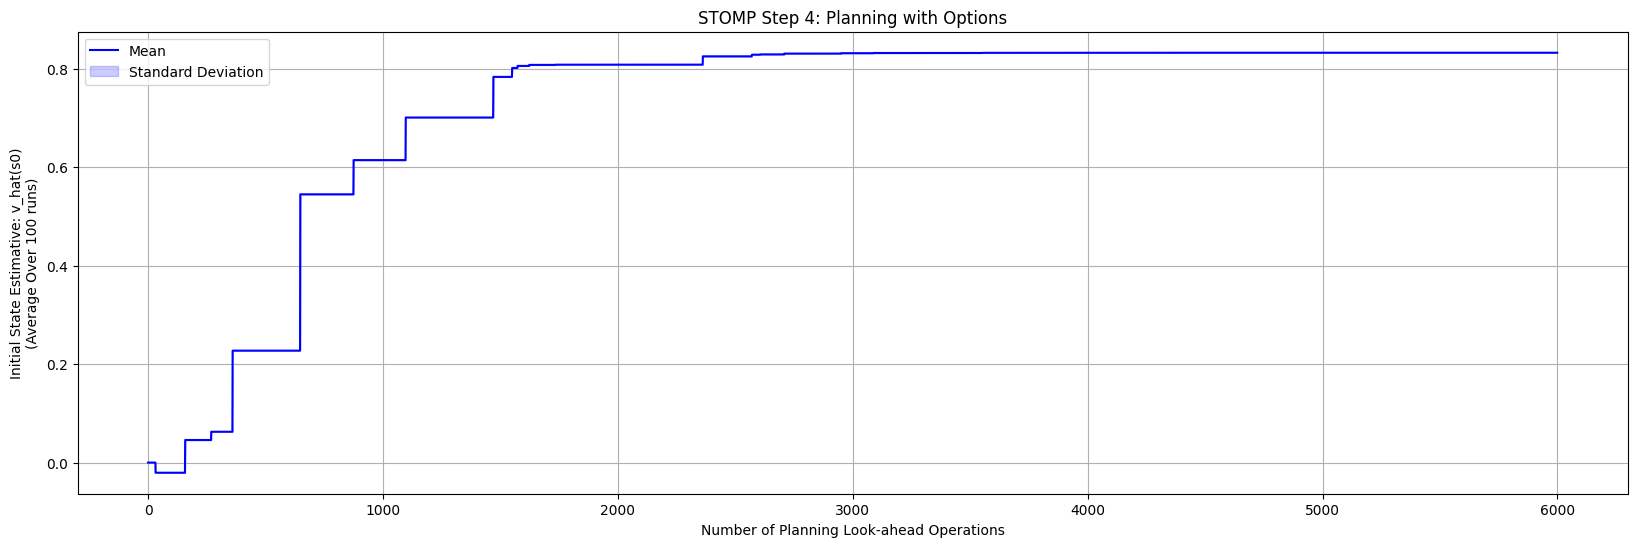

In [10]:
plot_arrays(
    planning_start_state_estimative_mean,
    planning_start_state_estimative_std,
    {
        "xlabel": "Number of Planning Look-ahead Operations",
        "ylabel": "Initial State Estimative: v_hat(s0)",
        "title": "STOMP Step 4: Planning with Options",
    },
)

# STOMP using updated classes

Here we run the STOMP progression experiments using the updated classes (temporary), to validade the
updated code is working as expected.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from common.utils import get_progress_bar
from gridworld.gridworld import TemporaryGridWorld as GridWorld
from gridworld.room_design import stomp_two_room_design as room_design
from stomp.temporary_framework import TemporarySTOMP as STOMP

In [ ]:
%load_ext autoreload
%autoreload 1
%aimport stomp.framework
%aimport gridworld.gridworld


In [ ]:
""" Experiment parameters """

num_runs = 1
number_of_steps = 50_000
number_of_lookahead_operations = 6_000


In [ ]:
all_runs = []
progress_bar = get_progress_bar(num_runs)

for run in progress_bar:
    subgoal_state_idx = 30  # hallway state in TwoRooms

    env = GridWorld(room_array=room_design)
    stomp = STOMP(
        env=env,
        subgoal_states_info={subgoal_state_idx: (7, 3)},  # hallway state position in the grid
    )

    env.reset()
    option_learning_logs, options_model_learning_logs, planning_logs = stomp.execute(
        off_policy_steps=number_of_steps,
        num_lookahead_operations=number_of_lookahead_operations,
    )
    all_runs.append((option_learning_logs, options_model_learning_logs, planning_logs))

    progress_bar.refresh()


In [ ]:
""" STOMP Step Logs """

# option learning
many_initial_state_estimatives = np.zeros((num_runs, number_of_steps))
many_rmse_of_state_values = np.zeros((num_runs, number_of_steps))

# model learning
many_reward_model_rmses = np.zeros((stomp.stomp_foundation.num_options, num_runs, number_of_steps))
many_transition_model_errors = np.zeros((stomp.stomp_foundation.num_options, num_runs, number_of_steps))

# planning
many_planning_estimatives = np.zeros((num_runs, number_of_lookahead_operations))

# unpack
for i, run in enumerate(all_runs):
    local_option_learning_logs = run[0]
    local_model_learning_logs = run[1]
    local_planning_logs = run[2]

    # option learning
    many_initial_state_estimatives[i] = local_option_learning_logs[0][0]
    many_rmse_of_state_values[i] = local_option_learning_logs[0][1]
    # model learning
    many_reward_model_rmses[4][i] = local_model_learning_logs[4][0]
    many_transition_model_errors[4][i] = local_model_learning_logs[4][1]
    # planning
    many_planning_estimatives[i] = local_planning_logs

assert many_initial_state_estimatives.shape == (num_runs, number_of_steps)
assert many_rmse_of_state_values.shape == (num_runs, number_of_steps)
assert many_reward_model_rmses.shape == (stomp.stomp_foundation.num_options, num_runs, number_of_steps)
assert many_transition_model_errors.shape == (stomp.stomp_foundation.num_options, num_runs, number_of_steps)
assert many_planning_estimatives.shape == (num_runs, number_of_lookahead_operations)

In [ ]:
def plot_arrays(
        mean_array,
        std_array,
        plotting_info,
        additional_mean_array=None,
        additional_std_array=None
    ):
    # Create figure and axis
    fig1, ax1 = plt.subplots(figsize=(18, 6))

    # Generate x-axis points (assuming these are sequential steps/episodes)
    x = np.arange(len(mean_array))

    # Plot mean line with shaded standard deviation
    ax1.plot(x, mean_array, label="Mean", color="skyblue")
    ax1.fill_between(
        x,
        mean_array - std_array,
        mean_array + std_array,
        color="skyblue",
        alpha=0.2,
        label="Standard Deviation",
    )

    # Customize the plot
    ax1.set_xlabel(plotting_info["xlabel"])
    ax1.set_ylabel(f"{plotting_info['ylabel']}\n(Average Over 100 runs)", color="blue")

    if additional_mean_array is not None and additional_std_array is not None:
        ax2 = ax1.twinx()  # Create a second y-axis
        ax2.plot(x, additional_mean_array, color="coral")
        ax2.fill_between(
            x,
            additional_mean_array - additional_std_array,
            additional_mean_array + additional_std_array,
            color="coral",
            alpha=0.2,
        )
        ax2.set_ylabel(f"{plotting_info['additional_ylabel']}\n(Average Over 100 runs)", color="red")

    plt.title(plotting_info["title"])
    plt.tight_layout()
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

In [ ]:
""" Option Learning Plot """
many_initial_state_estimatives_mean = np.mean(many_initial_state_estimatives, axis=0)
many_initial_state_estimatives_std = np.std(many_initial_state_estimatives, axis=0)

many_rmse_of_state_values_mean = np.mean(many_rmse_of_state_values, axis=0)
many_rmse_of_state_values_std = np.std(many_rmse_of_state_values, axis=0)

plot_arrays(
    many_initial_state_estimatives_mean,
    many_initial_state_estimatives_std,
    {
        "xlabel": "Steps of Off-Policy Experience",
        "ylabel": "Initial State Estimative: v_hat(s0)",
        "title": "STOMP Step 2: Option Learning",
        "additional_ylabel": "RMSE of State Values",
    },
    many_rmse_of_state_values_mean,
    many_rmse_of_state_values_std,
)

In [ ]:
""" Model Learning Plot """
many_transition_model_errors_mean = np.mean(many_transition_model_errors[4], axis=0)
many_transition_model_errors_std = np.std(many_transition_model_errors[4], axis=0)

many_reward_model_rmses_mean = np.mean(many_reward_model_rmses[4], axis=0)
many_reward_model_rmses_std = np.std(many_reward_model_rmses[4], axis=0)

plot_arrays(
    many_transition_model_errors_mean,
    many_transition_model_errors_std,
    {
        "xlabel": "Steps of Off-Policy Experience",
        "ylabel": "Transition Model Error",
        "title": "STOMP Step 3: Model Learning",
        "additional_ylabel": "Reward Model RMSE",
    },
    many_reward_model_rmses_mean,
    many_reward_model_rmses_std,
)


In [ ]:
""" Planning Plot """
many_planning_estimatives_mean = np.mean(many_planning_estimatives, axis=0)
many_planning_estimatives_std = np.std(many_planning_estimatives, axis=0)

plot_arrays(
    many_planning_estimatives_mean,
    many_planning_estimatives_std,
    {
        "xlabel": "Number of Planning Look-ahead Operations",
        "ylabel": "Initial State Estimative: v_hat(s0)",
        "title": "STOMP Step 4: Planning with Options",
    },
)
